# Final Project

## Solutions by: Nick Lewis, Zak Mehdi, Riccardo Gutgeld, Joey Recchia and Jesse Yan

In [23]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.regression.rolling import RollingOLS
from itertools import product
import concurrent.futures
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

#################################
# Helper Functions (From HW3)
#################################

def get_sector_tickers(sectors_to_include=None, sectors_to_exclude=None):
    sp500_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
    # Replace '.' with '-' to match Yahoo Finance tickers
    sp500_df['Symbol'] = sp500_df['Symbol'].str.replace('.', '-')
    sp500_sectors = sp500_df[['Symbol', 'GICS Sector']]

    if sectors_to_include:
        sp500_sectors = sp500_sectors[sp500_sectors['GICS Sector'].isin(sectors_to_include)]
    if sectors_to_exclude:
        sp500_sectors = sp500_sectors[~sp500_sectors['GICS Sector'].isin(sectors_to_exclude)]

    return sp500_sectors.groupby('GICS Sector')['Symbol'].apply(list).to_dict()

def get_highly_correlated_pairs(corr_matrix, threshold=0.9):
    correlated_pairs = []
    tickers = corr_matrix.columns
    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            if corr_matrix.iloc[i, j] >= threshold:
                correlated_pairs.append((tickers[i], tickers[j]))
    return correlated_pairs

def find_cointegrated_pairs(data, pairs, significance_level=0.05):
    coint_pairs = []
    pvalues = []
    for pair in tqdm(pairs, desc="Testing Cointegration"):
        s1 = data[pair[0]]
        s2 = data[pair[1]]
        result = ts.coint(s1, s2)
        pvalue = result[1]
        if pvalue < significance_level:
            coint_pairs.append(pair)
            pvalues.append(pvalue)
    return coint_pairs, pvalues

def evaluate_strategy(data, pair, entry, exit, stop_loss, window):
    try:
        S1, S2 = pair
        pair_data = data[[S1, S2]].dropna()
        if len(pair_data) < window:
            return None, None  # Not enough data for rolling window
        Y = pair_data[S1]
        X = sm.add_constant(pair_data[S2])
        rolling_model = RollingOLS(Y, X, window=window)
        rolling_results = rolling_model.fit()
        hedge_ratios = rolling_results.params[S2]
        intercepts = rolling_results.params['const']
        spread = Y - (hedge_ratios * pair_data[S2] + intercepts)
        spread_mean = spread.rolling(window=window).mean()
        spread_std = spread.rolling(window=window).std()
        zscore = (spread - spread_mean) / spread_std

        # Define entry/exit logic
        long_entries = (zscore < -entry) & ~(zscore < -stop_loss)  # Long entry, no stop-loss
        short_entries = (zscore > entry) & ~(zscore > stop_loss)  # Short entry, no stop-loss
        long_exit_combined = (zscore > -exit) | (zscore < -stop_loss)  # Long exit or stop-loss
        short_exit_combined = (zscore < exit) | (zscore > stop_loss)  # Short exit or stop-loss

        positions_S1 = pd.Series(0, index=pair_data.index)
        positions_S2 = pd.Series(0, index=pair_data.index)

        
        if long_entries.iloc[0]:
            positions_S1.iloc[0] = 1
            positions_S2.iloc[0] = -hedge_ratios.iloc[0]
        elif short_entries.iloc[0]:
            positions_S1.iloc[0] = -1
            positions_S2.iloc[0] = hedge_ratios.iloc[0]
        else:
            positions_S1.iloc[0] = 0
            positions_S2.iloc[0] = 0

        for t in range(1, len(zscore)):
            previous_position = positions_S1.iloc[t - 1]

            if previous_position == 0:
                # No position is open, check for entries
                if long_entries.iloc[t]:
                    # Open long position
                    positions_S1.iloc[t] = 1
                    positions_S2.iloc[t] = -hedge_ratios.iloc[t]
                elif short_entries.iloc[t]:
                    # Open short position
                    positions_S1.iloc[t] = -1
                    positions_S2.iloc[t] = hedge_ratios.iloc[t]
                else:
                    # Stay flat
                    positions_S1.iloc[t] = 0
                    positions_S2.iloc[t] = 0
            elif previous_position != 0:  # A position is open
                if (previous_position > 0 and long_exit_combined.iloc[t]) or \
                   (previous_position < 0 and short_exit_combined.iloc[t]):
                    # Close position
                    positions_S1.iloc[t] = 0
                    positions_S2.iloc[t] = 0
                else:
                    # Continue holding the current position
                    positions_S1.iloc[t] = previous_position
                    positions_S2.iloc[t] = positions_S2.iloc[t - 1]

        returns_S1 = pair_data[S1].pct_change()
        returns_S2 = pair_data[S2].pct_change()
        strategy_returns = positions_S1.shift(1) * returns_S1 + positions_S2.shift(1) * returns_S2
        strategy_returns.fillna(0, inplace=True)
        
        if strategy_returns.std() == 0:
            return None, None

        sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)
        return strategy_returns, sharpe_ratio
    except Exception:
        return None, None

def parallel_evaluate(data, pair, entry_thresholds, exit_thresholds, stop_loss_thresholds, rolling_windows):
    best_sharpe = -np.inf
    best_strategy = None
    best_params = None

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {
            executor.submit(evaluate_strategy, data, pair, entry, exit, stop_loss, window):
            (entry, exit, stop_loss, window)
            for entry, exit, stop_loss, window in product(entry_thresholds, exit_thresholds, stop_loss_thresholds, rolling_windows)
            if stop_loss > entry
        }

        for future in concurrent.futures.as_completed(futures):
            entry, exit, stop_loss, window = futures[future]
            try:
                strategy_returns, sharpe = future.result()
                if sharpe is not None and sharpe > best_sharpe:
                    best_sharpe = sharpe
                    best_strategy = strategy_returns
                    best_params = (entry, exit, stop_loss, window)
            except Exception:
                pass

    return best_strategy, best_params, best_sharpe

def test_train_split(data, train_duration=4, test_duration=1):
    if not isinstance(data.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a DatetimeIndex.")
    
    start_year = data.index.min().year
    end_year = data.index.max().year

    train_data_dict = {}
    test_data_dict = {}

    for test_start_year in range(start_year + train_duration, end_year + 1, test_duration):
        train_start = f"{test_start_year - train_duration}-01-01"
        train_end = f"{test_start_year - 1}-12-31"
        test_start = f"{test_start_year}-01-01"
        test_end = f"{test_start_year + test_duration - 1}-12-31"

        train_data = data.loc[train_start:train_end]
        test_data = data.loc[test_start:test_end]

        train_data_dict[test_start_year] = train_data
        test_data_dict[test_start_year] = test_data

    return train_data_dict, test_data_dict

def evaluate_strategy_test(data, pair, entry, exit, stop_loss, window):
    try:
        S1, S2 = pair
        pair_data = data[[S1, S2]].dropna()
        if len(pair_data) < window:
            return None, None, None  # Not enough data for rolling window
        Y = pair_data[S1]
        X = sm.add_constant(pair_data[S2])
        rolling_model = RollingOLS(Y, X, window=window)
        rolling_results = rolling_model.fit()
        hedge_ratios = rolling_results.params[S2]
        intercepts = rolling_results.params['const']
        spread = Y - (hedge_ratios * pair_data[S2] + intercepts)
        spread_mean = spread.rolling(window=window).mean()
        spread_std = spread.rolling(window=window).std()
        zscore = (spread - spread_mean) / spread_std

        # Define entry/exit logic
        long_entries = (zscore < -entry) & ~(zscore < -stop_loss)  # Long entry, no stop-loss
        short_entries = (zscore > entry) & ~(zscore > stop_loss)  # Short entry, no stop-loss
        long_exit_combined = (zscore > -exit) | (zscore < -stop_loss)  # Long exit or stop-loss
        short_exit_combined = (zscore < exit) | (zscore > stop_loss)  # Short exit or stop-loss

        positions_S1 = pd.Series(0, index=pair_data.index)
        positions_S2 = pd.Series(0, index=pair_data.index)
        log_entries = []

        # Handle t=0 explicitly
        if long_entries.iloc[0]:
            positions_S1.iloc[0] = 1
            positions_S2.iloc[0] = -hedge_ratios.iloc[0]
            log_entries.append({'Date': positions_S1.index[0], 'Ticker': S1, 'Pair': pair, 'Volume': positions_S1.iloc[0], 'Entry/Exit': 1})
            log_entries.append({'Date': positions_S2.index[0], 'Ticker': S2, 'Pair': pair, 'Volume': positions_S2.iloc[0], 'Entry/Exit': 1})
        elif short_entries.iloc[0]:
            positions_S1.iloc[0] = -1
            positions_S2.iloc[0] = hedge_ratios.iloc[0]
            log_entries.append({'Date': positions_S1.index[0], 'Ticker': S1, 'Pair': pair, 'Volume': positions_S1.iloc[0], 'Entry/Exit': 1})
            log_entries.append({'Date': positions_S2.index[0], 'Ticker': S2, 'Pair': pair, 'Volume': positions_S2.iloc[0], 'Entry/Exit': 1})
        else:
            positions_S1.iloc[0] = 0
            positions_S2.iloc[0] = 0

        # Loop from t=1 to len(zscore)
        for t in range(1, len(zscore)):
            previous_position = positions_S1.iloc[t - 1]

            if previous_position == 0:
                if long_entries.iloc[t]:
                    positions_S1.iloc[t] = 1
                    positions_S2.iloc[t] = -hedge_ratios.iloc[t]
                    log_entries.append({'Date': positions_S1.index[t], 'Ticker': S1, 'Pair': pair, 'Volume': positions_S1.iloc[t], 'Entry/Exit': 1})
                    log_entries.append({'Date': positions_S2.index[t], 'Ticker': S2, 'Pair': pair, 'Volume': positions_S2.iloc[t], 'Entry/Exit': 1})
                elif short_entries.iloc[t]:
                    positions_S1.iloc[t] = -1
                    positions_S2.iloc[t] = hedge_ratios.iloc[t]
                    log_entries.append({'Date': positions_S1.index[t], 'Ticker': S1, 'Pair': pair, 'Volume': positions_S1.iloc[t], 'Entry/Exit': 1})
                    log_entries.append({'Date': positions_S2.index[t], 'Ticker': S2, 'Pair': pair, 'Volume': positions_S2.iloc[t], 'Entry/Exit': 1})
                else:
                    positions_S1.iloc[t] = 0
                    positions_S2.iloc[t] = 0
            elif previous_position != 0:
                if (previous_position > 0 and long_exit_combined.iloc[t]) or \
                   (previous_position < 0 and short_exit_combined.iloc[t]):
                    log_entries.append({'Date': positions_S1.index[t], 'Ticker': S1, 'Pair': pair, 'Volume': previous_position, 'Entry/Exit': -1})
                    log_entries.append({'Date': positions_S2.index[t], 'Ticker': S2, 'Pair': pair, 'Volume': positions_S2.iloc[t - 1], 'Entry/Exit': -1})
                    positions_S1.iloc[t] = 0
                    positions_S2.iloc[t] = 0
                else:
                    positions_S1.iloc[t] = previous_position
                    positions_S2.iloc[t] = positions_S2.iloc[t - 1]

        # Final exit trades
        if positions_S1.iloc[-1] != 0:
            log_entries.append({'Date': positions_S1.index[-1], 'Ticker': S1, 'Pair': pair, 'Volume': positions_S1.iloc[-1], 'Entry/Exit': -1})
        if positions_S2.iloc[-1] != 0:
            log_entries.append({'Date': positions_S2.index[-1], 'Ticker': S2, 'Pair': pair, 'Volume': positions_S2.iloc[-1], 'Entry/Exit': -1})

        # Create trader log DataFrame from log_entries
        trader_log = pd.DataFrame(log_entries)

        # Calculate strategy returns
        returns_S1 = pair_data[S1].pct_change()
        returns_S2 = pair_data[S2].pct_change()
        strategy_returns = positions_S1.shift(1) * returns_S1 + positions_S2.shift(1) * returns_S2
        strategy_returns.fillna(0, inplace=True)

        if strategy_returns.std() == 0:
            return None, None, None

        sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)
        return strategy_returns, sharpe_ratio, trader_log
    except Exception as e:
        print(f"Exception occurred: {e}")
        return None, None, None

## 1. Benchmark Definition and Data Collection

For our pairs trading strategy focused on the IT sector, we will use the Technology Select Sector SPDR Fund (XLK) as the benchmark. XLK is an ETF designed to track the performance of companies from the IT sector of the S&P 500. This makes it a suitable reference point to measure whether our strategy adds value relative to a simple "passive" exposure to the sector.


In [5]:
BENCHMARK_TICKER = "XLK"
START = "2014-12-31"
END = "2023-12-31"

included_sectors = ["Information Technology"] 
sector_tickers = get_sector_tickers(sectors_to_include=included_sectors)
# Limit to 10 tickers for faster processing but need to be changed by to entire sector
it_tickers = sector_tickers.get("Information Technology", [])

data = pd.DataFrame()
volume = pd.DataFrame()
for ticker in tqdm(it_tickers, desc="Downloading IT Tickers"):
    try:
        df = yf.download(ticker, start=START, end=END, progress=False)
        if not df.empty:
            data[ticker] = df['Adj Close']
            volume[ticker] = df['Volume']
    except Exception as e:
        print(f"Could not download {ticker}: {e}")

data.dropna(axis=1, inplace=True)
volume = volume.replace(0, method='ffill')

if data.shape[1] < 2:
    raise ValueError("Not enough tickers with sufficient data.")

data_rets = data.pct_change()
data_rets = data_rets.iloc[1:].copy()

data = data.iloc[1:].copy()
volume = volume.iloc[1:].copy()

dollar_volume = data * volume

In [6]:
train_data_dict, test_data_dict = test_train_split(data, train_duration=4, test_duration=1)
dv_train, dv_test = test_train_split(dollar_volume)
rets_train, rets_test = test_train_split(data_rets)

cointegrated_pairs_dict = {}

for year, ret_train in rets_train.items():
    dv_data = dv_train[year]
    eligible_stocks = dv_data.columns[dv_data.median() >= 1e8]
    filtered_ret_train = ret_train[eligible_stocks]

    if filtered_ret_train.empty:
        print(f"No eligible stocks for year {year} based on dollar volume criteria.")
        continue

    corr_matrix = filtered_ret_train.corr().abs()
    high_corr_pairs = get_highly_correlated_pairs(corr_matrix, threshold=0.75)
    cointegrated_pairs, pvalues = find_cointegrated_pairs(filtered_ret_train, high_corr_pairs, significance_level=0.05)

    coint_df = pd.DataFrame({
        'Pair': cointegrated_pairs,
        'P-Value': pvalues
    }).sort_values('P-Value')

    print(f"\nYear: {year}")
    print("\nTop Cointegrated Pairs:")
    display(coint_df.head())

    if not coint_df.empty:
        cointegrated_pairs_dict[year] = cointegrated_pairs
    else:
        print(f"No cointegrated pairs found for year {year}.")

Testing Cointegration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.23it/s]


Year: 2019

Top Cointegrated Pairs:


,Pair,P-Value
0,"(AMAT, LRCX)",8.288300e-29


Testing Cointegration: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 41.79it/s]


Year: 2020

Top Cointegrated Pairs:


,Pair,P-Value
0,"(ADI, MCHP)",0.000000e+00
1,"(ADI, TXN)",0.000000e+00
2,"(AMAT, KLAC)",0.000000e+00
3,"(AMAT, LRCX)",0.000000e+00
4,"(KLAC, LRCX)",2.874389e-28


Testing Cointegration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 43.46it/s]


Year: 2021

Top Cointegrated Pairs:


,Pair,P-Value
20,"(SWKS, TXN)",0.0
2,"(ADI, AMAT)",0.0
3,"(ADI, MCHP)",0.0
16,"(KLAC, LRCX)",0.0
5,"(ADI, SWKS)",0.0


Testing Cointegration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 41.83it/s]


Year: 2022

Top Cointegrated Pairs:


,Pair,P-Value
0,"(AAPL, MSFT)",0.0
38,"(MU, WDC)",0.0
35,"(MCHP, SWKS)",0.0
29,"(KLAC, TXN)",0.0
26,"(KLAC, LRCX)",0.0


Testing Cointegration: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:01<00:00, 43.19it/s]


Year: 2023

Top Cointegrated Pairs:


,Pair,P-Value
40,"(AVGO, ON)",0.0
31,"(ANSS, MSFT)",0.0
33,"(APH, CDW)",0.0
34,"(APH, GLW)",0.0
35,"(APH, MCHP)",0.0


In [7]:
%%time
entry_thresholds = np.arange(1.5, 2.6, 0.5)
exit_thresholds = np.arange(0.3, 1.1, 0.2)
stop_loss_thresholds = np.arange(1.65, 3.2, 0.5)
rolling_windows = range(10, 31, 5)

# Store results
all_results = {}

for year, train_data in train_data_dict.items():
    cointegrated_pairs = cointegrated_pairs_dict.get(year, [])

    if not cointegrated_pairs:
        print(f"No cointegrated pairs for year {year}. Skipping optimization.")
        continue

    print(f"Optimizing strategies for year {year}...")
    all_strategy_returns = pd.DataFrame()
    best_results = []

    for pair in tqdm(cointegrated_pairs, desc=f"Optimizing Pairs for {year}"):
        best_strategy, best_params, best_sharpe = parallel_evaluate(
            train_data, pair, entry_thresholds, exit_thresholds, stop_loss_thresholds, rolling_windows
        )

        if best_strategy is not None:
            all_strategy_returns[pair] = best_strategy
            best_results.append((pair, *best_params, best_sharpe))

    if not best_results:
        print(f"No successful strategies found for year {year}.")
        continue

    best_results_df = pd.DataFrame(
        best_results,
        columns=['Pair', 'Entry Threshold', 'Exit Threshold', 'Stop-Loss Threshold', 'Rolling Window', 'Sharpe Ratio']
    )
    print(f"\nTop Results for {year}:")
    display(best_results_df.sort_values('Sharpe Ratio', ascending=False))

    portfolio_returns = all_strategy_returns.mean(axis=1)

    all_results[year] = {
        "best_results_df": best_results_df,
        "portfolio_returns": portfolio_returns,
        "strategy_returns": all_strategy_returns
    }

print("Optimization complete.")

Optimizing strategies for year 2019...


Optimizing Pairs for 2019: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.74s/it]


Top Results for 2019:


,Pair,Entry Threshold,Exit Threshold,Stop-Loss Threshold,Rolling Window,Sharpe Ratio
0,"(AMAT, LRCX)",2.5,0.7,3.15,30,1.312792


Optimizing strategies for year 2020...


Optimizing Pairs for 2020: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:27<00:00, 14.54s/it]


Top Results for 2020:


,Pair,Entry Threshold,Exit Threshold,Stop-Loss Threshold,Rolling Window,Sharpe Ratio
3,"(AMAT, LRCX)",2.5,0.7,3.15,30,1.383680
0,"(ADI, MCHP)",1.5,0.7,1.65,20,1.272201
4,"(KLAC, LRCX)",2.0,0.3,3.15,30,0.922178
5,"(MCHP, TXN)",2.5,0.3,2.65,30,0.899413
1,"(ADI, TXN)",2.5,0.7,2.65,30,0.853685
2,"(AMAT, KLAC)",1.5,0.3,1.65,30,0.829458


Optimizing strategies for year 2021...


Optimizing Pairs for 2021: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [05:02<00:00, 14.43s/it]


Top Results for 2021:


,Pair,Entry Threshold,Exit Threshold,Stop-Loss Threshold,Rolling Window,Sharpe Ratio
20,"(SWKS, TXN)",2.5,0.3,3.15,25,1.518646
17,"(MCHP, ON)",2.0,0.5,2.65,25,1.422916
0,"(ADBE, CRM)",2.5,0.3,2.65,20,1.252701
3,"(ADI, MCHP)",1.5,0.5,1.65,20,1.233256
9,"(AMAT, MCHP)",1.5,0.3,2.15,25,1.073115
14,"(INTU, MSFT)",2.5,0.3,3.15,20,1.065601
4,"(ADI, ON)",1.5,0.3,2.15,30,1.060151
19,"(MSFT, SNPS)",1.5,0.7,3.15,15,1.060092
1,"(ADBE, MSFT)",2.0,0.7,2.65,20,1.038850
8,"(AMAT, LRCX)",1.5,0.3,1.65,20,0.985688


Optimizing strategies for year 2022...


Optimizing Pairs for 2022: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [09:49<00:00, 14.37s/it]


Top Results for 2022:


,Pair,Entry Threshold,Exit Threshold,Stop-Loss Threshold,Rolling Window,Sharpe Ratio
6,"(ADI, KLAC)",1.5,0.7,2.65,30,1.533183
40,"(SWKS, TXN)",2.5,0.3,3.15,25,1.419853
14,"(AMAT, MCHP)",2.0,0.9,2.15,25,1.414951
27,"(KLAC, MCHP)",2.5,0.3,3.15,15,1.362188
18,"(ANSS, INTU)",2.0,0.7,2.15,30,1.330804
1,"(ADBE, ANSS)",2.5,0.7,2.65,30,1.274849
34,"(MCHP, ON)",2.0,0.5,2.65,25,1.256931
0,"(AAPL, MSFT)",2.0,0.3,2.15,20,1.225382
38,"(MU, WDC)",2.0,0.9,2.15,20,1.224142
29,"(KLAC, TXN)",1.5,0.7,1.65,25,1.224010


Optimizing strategies for year 2023...


Optimizing Pairs for 2023: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [20:03<00:00, 14.86s/it]


Top Results for 2023:


,Pair,Entry Threshold,Exit Threshold,Stop-Loss Threshold,Rolling Window,Sharpe Ratio
35,"(APH, MCHP)",2.0,0.7,2.65,20,1.811142
12,"(ADI, ON)",1.5,0.3,2.15,30,1.439575
24,"(AMAT, ON)",1.5,0.3,1.65,20,1.436129
79,"(SWKS, TXN)",2.5,0.3,3.15,25,1.393153
44,"(CDNS, MSFT)",2.0,0.3,2.15,25,1.367458
...,...,...,...,...,...,...
4,"(ADBE, SNPS)",2.0,0.3,2.15,25,0.577958
66,"(MCHP, TER)",2.5,0.7,2.65,15,0.556983
65,"(MCHP, SWKS)",2.5,0.9,3.15,15,0.543707
16,"(ADSK, ANSS)",2.0,0.3,2.15,15,0.459603


Optimization complete.
CPU times: user 1h 11min 2s, sys: 17min 24s, total: 1h 28min 26s
Wall time: 36min 38s


In [8]:
TRADING_COST = 6.5e-4

With the best parameters, we run it on the test data:

In [33]:
test_returns_df = pd.DataFrame(columns=['Date', 'Year', 'Pair', 'Return'])
trade_log = pd.DataFrame(columns=['Date', 'Year', 'Ticker', 'Volume', 'Entry/Exit'])
portfolio_test_returns_df = pd.DataFrame()

for year, results in all_results.items():
    test_data = test_data_dict[year]
    best_results_df = results["best_results_df"]

    best_results_df['Test Sharpe'] = 0
    test_returns = pd.DataFrame()

    for index, row in best_results_df.iterrows():
        test_return, test_sharpe, trade_log_year = evaluate_strategy_test(
            test_data,
            row['Pair'],
            row['Entry Threshold'],
            row['Exit Threshold'],
            row['Stop-Loss Threshold'],
            row['Rolling Window']
        )

        if test_return is not None:
            test_returns[row['Pair']] = test_return
            best_results_df.loc[index, 'Test Sharpe'] = test_sharpe

            pair_returns_df = pd.DataFrame({
                'Date': test_return.index,
                'Year': year,
                'Pair': [row['Pair']] * len(test_return),
                'Return': test_return.values
            })
            test_returns_df = pd.concat([test_returns_df, pair_returns_df], ignore_index=True)

        if trade_log_year is not None:
            trade_log_year['Year'] = year
            trade_log = pd.concat([trade_log, trade_log_year], ignore_index=True)

    portfolio_test_returns = test_returns.mean(axis=1) if not test_returns.empty else pd.Series(0, index=test_data.index)

    portfolio_year_df = pd.DataFrame({
        'Date': portfolio_test_returns.index,
        'Year': year,
        'Return': portfolio_test_returns.values
    })
    portfolio_test_returns_df = pd.concat([portfolio_test_returns_df, portfolio_year_df], ignore_index=True)

    cumulative_portfolio_returns = (1 + portfolio_test_returns).cumprod() - 1
    all_results[year]["portfolio_test_returns"] = portfolio_test_returns

    print(f"\nCumulative Portfolio Returns for Year: {year}")
    display(cumulative_portfolio_returns)

print("\nTest Returns DataFrame:")
display(test_returns_df)

print("\nPortfolio Test Returns DataFrame:")
display(portfolio_test_returns_df)


Cumulative Portfolio Returns for Year: 2019


Date
2019-01-02    0.000000
2019-01-03    0.000000
2019-01-04    0.000000
2019-01-07    0.000000
2019-01-08    0.000000
                ...   
2019-12-24    0.370007
2019-12-26    0.370007
2019-12-27    0.370007
2019-12-30    0.370007
2019-12-31    0.370007
Length: 252, dtype: float64


Cumulative Portfolio Returns for Year: 2020


Date
2020-01-02    0.000000
2020-01-03    0.000000
2020-01-06    0.000000
2020-01-07    0.000000
2020-01-08    0.000000
                ...   
2020-12-24    0.001815
2020-12-28    0.001815
2020-12-29    0.001815
2020-12-30    0.001815
2020-12-31    0.001815
Length: 253, dtype: float64


Cumulative Portfolio Returns for Year: 2021


Date
2021-01-04    0.000000
2021-01-05    0.000000
2021-01-06    0.000000
2021-01-07    0.000000
2021-01-08    0.000000
                ...   
2021-12-27   -0.020012
2021-12-28   -0.020380
2021-12-29   -0.020351
2021-12-30   -0.020832
2021-12-31   -0.020289
Length: 252, dtype: float64


Cumulative Portfolio Returns for Year: 2022


Date
2022-01-03    0.000000
2022-01-04    0.000000
2022-01-05    0.000000
2022-01-06    0.000000
2022-01-07    0.000000
                ...   
2022-12-23    0.003711
2022-12-27    0.003004
2022-12-28    0.002394
2022-12-29    0.003243
2022-12-30    0.003575
Length: 251, dtype: float64


Cumulative Portfolio Returns for Year: 2023


Date
2023-01-03    0.000000
2023-01-04    0.000000
2023-01-05    0.000000
2023-01-06    0.000000
2023-01-09    0.000000
                ...   
2023-12-22   -0.049229
2023-12-26   -0.051014
2023-12-27   -0.050714
2023-12-28   -0.050577
2023-12-29   -0.050333
Length: 250, dtype: float64


Test Returns DataFrame:


,Date,Year,Pair,Return
0,2019-01-02,2019,"(AMAT, LRCX)",0.000000
1,2019-01-03,2019,"(AMAT, LRCX)",-0.000000
2,2019-01-04,2019,"(AMAT, LRCX)",0.000000
3,2019-01-07,2019,"(AMAT, LRCX)",0.000000
4,2019-01-08,2019,"(AMAT, LRCX)",-0.000000
...,...,...,...,...
37348,2023-12-22,2023,"(TER, TXN)",0.000000
37349,2023-12-26,2023,"(TER, TXN)",0.000000
37350,2023-12-27,2023,"(TER, TXN)",0.000000
37351,2023-12-28,2023,"(TER, TXN)",0.000000



Portfolio Test Returns DataFrame:


,Date,Year,Return
0,2019-01-02,2019,0.000000
1,2019-01-03,2019,0.000000
2,2019-01-04,2019,0.000000
3,2019-01-07,2019,0.000000
4,2019-01-08,2019,0.000000
...,...,...,...
1253,2023-12-22,2023,-0.002773
1254,2023-12-26,2023,-0.001877
1255,2023-12-27,2023,0.000316
1256,2023-12-28,2023,0.000144


Transaction Costs:

In [42]:
test_returns_pivot = test_returns_df.pivot(index='Date', columns='Pair', values='Return')

test_returns_pivot = test_returns_pivot.fillna(0)

test_returns_pivot.columns = [pair for pair in test_returns_pivot.columns]

print("Reformatted Test Returns DataFrame:")
display(test_returns_pivot)

unique_combinations = trade_log[['Pair', 'Date']].drop_duplicates()

for _, row in unique_combinations.iterrows():
    pair = tuple(row['Pair'])  # Get the pair as a tuple
    date = row['Date']

    if pair in test_returns_pivot.columns and date in test_returns_pivot.index:
        test_returns_pivot.at[date, pair] -= TRADING_COST

port_test_rets_post_costs = test_returns_pivot.mean(axis=1)
cum_port_ret_post_costs = (1 + port_test_rets_post_costs).cumprod() - 1
cum_port_ret_post_costs

Reformatted Test Returns DataFrame:


,"(AAPL, MSFT)","(ADBE, ANSS)","(ADBE, CDNS)","(ADBE, CRM)","(ADBE, MSFT)","(ADBE, NOW)","(ADBE, SNPS)","(ADI, AMAT)","(ADI, AVGO)","(ADI, KLAC)",...,"(MPWR, TXN)","(MSFT, SNPS)","(MU, WDC)","(NXPI, ON)","(NXPI, SWKS)","(NXPI, TEL)","(NXPI, TER)","(NXPI, TXN)","(SWKS, TXN)","(TER, TXN)"
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2019-01-03,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2019-01-04,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2019-01-07,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2019-01-08,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.0,-0.142143,-0.003363,0.0,0.0,0.0,-0.0,0.0,0.0,0.002579,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2023-12-26,0.0,-0.007083,0.002779,0.0,0.0,0.0,-0.0,0.0,0.0,0.002667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2023-12-27,0.0,0.000599,-0.002301,0.0,-0.0,0.0,-0.0,0.0,0.0,0.002342,...,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


Date
2019-01-02    0.000000
2019-01-03    0.000000
2019-01-04    0.000000
2019-01-07    0.000000
2019-01-08    0.000000
                ...   
2023-12-22   -0.060936
2023-12-26   -0.062686
2023-12-27   -0.062419
2023-12-28   -0.062309
2023-12-29   -0.062126
Length: 1258, dtype: float64

No Transaction Costs

In [25]:
display(trade_log)
cum_port_ret = (1+portfolio_test_returns_df['Return']).cumprod() - 1
display(cum_port_ret)

,Date,Year,Ticker,Volume,Entry/Exit,Pair
0,2019-07-24,2019,AMAT,1.000000,1,"(AMAT, LRCX)"
1,2019-07-24,2019,LRCX,-4.000617,1,"(AMAT, LRCX)"
2,2019-08-06,2019,AMAT,1.000000,-1,"(AMAT, LRCX)"
3,2019-08-06,2019,LRCX,-4.000617,-1,"(AMAT, LRCX)"
4,2019-08-16,2019,AMAT,1.000000,1,"(AMAT, LRCX)"
...,...,...,...,...,...,...
4371,2023-12-19,2023,TXN,0.439566,-1,"(TER, TXN)"
4372,2023-12-28,2023,TER,1.000000,1,"(TER, TXN)"
4373,2023-12-28,2023,TXN,-1.222101,1,"(TER, TXN)"
4374,2023-12-29,2023,TER,1.000000,-1,"(TER, TXN)"


2019-01-02         0.0
2019-01-03         0.0
2019-01-04         0.0
2019-01-07         0.0
2019-01-08         0.0
                ...   
2023-12-22    0.283021
2023-12-26    0.280613
2023-12-27    0.281018
2023-12-28    0.281203
2023-12-29    0.281532
Name: Return, Length: 1258, dtype: object

### Actual PnL/Return Calculation

In [11]:
trade_log['Dollar Volume'] = trade_log.apply(
    lambda row: dollar_volume.loc[row['Date'], row['Ticker']], axis=1
)
trade_log['Price'] = trade_log.apply(
    lambda row: data.loc[row['Date'], row['Ticker']], axis=1
)

In [12]:
# Initialize variables for actual volumes
actual_volumes = {}

# Iterate through rows to calculate Actual Volume
for idx, row in trade_log.iterrows():
    if row['Entry/Exit'] == 1:  # Entry
        # Calculate Real Dollar Volume
        real_dollar_volume = row['Dollar Volume'] / row['Volume']

        # Calculate Actual Volume for the entry
        actual_volume = round((real_dollar_volume * 0.02) / row['Price'])
        trade_log.at[idx, 'Actual Volume'] = actual_volume

        # Store the Actual Volume for the ticker
        actual_volumes[row['Ticker']] = actual_volume

    elif row['Entry/Exit'] == -1:  # Exit
        # Retrieve Actual Volume for the corresponding entry ticker
        trade_log.at[idx, 'Actual Volume'] = actual_volumes.get(row['Ticker'], None)

display(trade_log)
print('Minimum Maximized DV that does not exceed 2% restriction (no slippage):')
min_dv = (trade_log['Price'] * trade_log['Actual Volume']).abs().min()
min_dv

,Date,Year,Ticker,Volume,Entry/Exit,Dollar Volume,Price,Actual Volume
0,2019-07-24,2019,AMAT,1.000000,1,5.573305e+08,49.365845,225796.0
1,2019-07-24,2019,LRCX,-4.000617,1,4.559829e+08,14.518048,-157016.0
2,2019-08-06,2019,AMAT,1.000000,-1,3.258378e+08,43.864971,225796.0
3,2019-08-06,2019,LRCX,-4.000617,-1,2.607867e+08,13.015258,-157016.0
4,2019-08-16,2019,AMAT,1.000000,1,7.795922e+08,44.149017,353164.0
...,...,...,...,...,...,...,...,...
4371,2023-12-19,2023,TXN,0.439566,-1,7.174867e+08,163.832199,214502.0
4372,2023-12-28,2023,TER,1.000000,1,9.619567e+07,109.988190,17492.0
4373,2023-12-28,2023,TXN,-1.222101,1,5.047292e+08,166.963013,-49472.0
4374,2023-12-29,2023,TER,1.000000,-1,1.476103e+08,108.076057,17492.0


Minimum Maximized DV that does not exceed 2% restriction (no slippage):


238843.79928588867

In [13]:
earliest_test_year = min(test_data_dict.keys())
start_date = f"{earliest_test_year}-01-01"

filtered_data_index = data.index[data.index >= start_date]

pnl_df = pd.DataFrame(index=filtered_data_index, columns=['Current PnL', 'Realized PnL', 'Cumulative PnL', 'Gross Traded Value', 'Transaction Costs'])
pnl_df[:] = 0.0

open_positions = {}
realized_pnl = 0.0

for current_date in filtered_data_index:
    trades_today = trade_log[trade_log['Date'] == current_date]

    gross_traded_value = 0.0

    for _, row in trades_today.iterrows():
        ticker = row['Ticker']
        if row['Entry/Exit'] == 1:
            entry_value = abs(row['Price'] * row['Actual Volume'])
            open_positions[ticker] = {
                'Actual Volume': row['Actual Volume'],
                'Entry Price': row['Price'] * row['Actual Volume']
            }
            gross_traded_value += entry_value
        elif row['Entry/Exit'] == -1:
            if ticker in open_positions:
                entry_value = open_positions[ticker]['Entry Price']
                exit_value = row['Price'] * open_positions[ticker]['Actual Volume']
                realized_pnl += exit_value - entry_value
                del open_positions[ticker]
                gross_traded_value += abs(row['Price'] * row['Actual Volume'])

    current_pnl = 0.0
    for ticker, position in open_positions.items():
        if ticker in data.columns:
            current_price = data.loc[current_date, ticker]
            current_value = current_price * position['Actual Volume']
            current_pnl += current_value - position['Entry Price']

    cumulative_pnl = realized_pnl + current_pnl
    transaction_costs = gross_traded_value * TRADING_COST

    pnl_df.at[current_date, 'Current PnL'] = current_pnl
    pnl_df.at[current_date, 'Realized PnL'] = realized_pnl
    pnl_df.at[current_date, 'Cumulative PnL'] = cumulative_pnl
    pnl_df.at[current_date, 'Gross Traded Value'] = gross_traded_value
    pnl_df.at[current_date, 'Transaction Costs'] = transaction_costs

display(pnl_df)

,Current PnL,Realized PnL,Cumulative PnL,Gross Traded Value,Transaction Costs
Date,,,,,
2019-01-02,0.0,0.0,0.0,0.0,0.0
2019-01-03,0.0,0.0,0.0,0.0,0.0
2019-01-04,0.0,0.0,0.0,0.0,0.0
2019-01-07,0.0,0.0,0.0,0.0,0.0
2019-01-08,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2023-12-22,1032346.790215,-345882950.124868,-344850603.334654,41707643.45916,27109.968248
2023-12-26,1025120.839302,-345639907.4503,-344614786.610998,153326624.519051,99662.305937
2023-12-27,1933500.833649,-345344912.465567,-343411411.631918,158195785.167679,102827.260359


In [14]:
print("\nIT data:")
display(data)


IT data:


,ACN,ADBE,AMD,AKAM,APH,ADI,ANSS,AAPL,AMAT,ANET,...,SNPS,TEL,TDY,TER,TXN,TRMB,TYL,VRSN,WDC,ZBRA
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,75.312744,72.339996,2.670000,63.250000,12.205958,45.085960,81.639999,24.347174,21.982445,3.917500,...,43.099998,52.534218,102.160004,18.383680,40.842304,26.910000,107.849998,57.189999,92.755730,77.430000
2015-01-05,74.041138,71.980003,2.660000,61.939999,11.982956,44.266060,80.860001,23.661270,21.277876,3.987500,...,42.540001,51.511292,99.720001,18.038393,40.208427,26.030001,105.970001,56.240002,91.529434,76.339996
2015-01-06,73.507065,70.529999,2.630000,60.669998,11.830495,43.226986,79.260002,23.663504,20.476437,3.988125,...,42.160000,50.887577,98.019997,17.487825,39.544018,25.660000,104.910004,55.180000,89.488342,75.790001
2015-01-07,75.049950,71.110001,2.580000,60.160000,12.033018,43.681595,79.709999,23.995317,20.670193,4.071250,...,42.209999,52.417786,98.790001,17.627798,40.254250,25.340000,106.029999,55.639999,90.832260,77.720001
2015-01-08,76.194382,72.919998,2.610000,61.570000,12.267401,44.452782,81.660004,24.917267,21.330721,4.132500,...,42.860001,53.473965,100.440002,18.178371,40.911018,25.670000,109.199997,56.880001,92.713745,79.379997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,348.842255,598.750000,139.600006,119.620003,49.198139,193.812241,357.980011,192.656189,160.794418,59.564999,...,524.460022,139.182907,433.450012,107.189690,163.579407,52.439999,415.000000,206.389999,52.660000,269.410004
2023-12-26,347.838348,598.260010,143.410004,119.480003,49.436653,195.552704,360.880005,192.108856,163.007126,59.382500,...,520.250000,139.538345,437.480011,109.898560,166.078217,53.189999,416.410004,206.830002,52.759998,275.500000
2023-12-27,348.222198,596.080017,146.070007,119.000000,49.426716,196.024704,358.899994,192.208359,162.937683,59.432499,...,518.099976,138.985443,441.730011,110.296928,166.486572,53.330002,415.600006,205.750000,52.419998,275.790009


In [15]:
xlk_data = yf.download(BENCHMARK_TICKER, start=START, end=END, progress=False)
xlk_data.dropna(inplace=True)

print("\nBenchmark (XLK) Data:")
display(xlk_data.head())



Benchmark (XLK) Data:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-31,41.950001,42.000000,41.310001,41.349998,36.569572,5955300
2015-01-02,41.610001,41.709999,41.060001,41.270000,36.498821,8495200
2015-01-05,41.119999,41.119999,40.520000,40.639999,35.941647,7194700
2015-01-06,40.759998,40.759998,39.959999,40.150002,35.508308,8745600
2015-01-07,40.459999,40.590000,40.200001,40.490002,35.809006,6534600


## 2. Returns Calculation:

In [16]:
it_returns = data.pct_change().dropna()

strategy_returns = portfolio_test_returns_df['Return'].astype(float) # pd.concat([portfolio_returns, portfolio_test_returns], axis=0).astype(float) # portfolio_returns #it_returns.mean(axis=1)

xlk_data['XLK_Returns'] = xlk_data['Adj Close'].pct_change()
benchmark_returns = xlk_data['XLK_Returns'].dropna()

aligned_data = pd.concat([strategy_returns, benchmark_returns], axis=1, join='inner')
aligned_data.columns = ['Strategy_Returns', 'XLK_Returns']
aligned_data.dropna(inplace=True)

print("\nAligned Strategy and Benchmark Returns:")
display(aligned_data.head())


Aligned Strategy and Benchmark Returns:


,Strategy_Returns,XLK_Returns
2019-01-02,0.0,0.000645
2019-01-03,0.0,-0.050468
2019-01-04,0.0,0.044320
2019-01-07,0.0,0.008943
2019-01-08,0.0,0.008381


## 3. Attribution Model Selection

The Brinson-Fachler model decomposes active portfolio returns into two primary sources: 
- Allocation effects : How the portfolio’s over/underweighting in certain sectors compares to a benchmark.
- Selection Effects: How security selection within a sector compares to the benchmark’s returns for that sector.

In our strategy, we are not making top-down allocation decisions across sectors; we are confined to a single sector. Thus, the allocation effect does not apply. We are not simply picking stocks to outperform a benchmark weight; we are trading relative-value spreads between pairs of stocks. The goal is to profit from mean reversion within a narrow subset of the sector, aiming for returns that are largely independent of the general market direction.

Given that our strategy is equity-based, a fixed-income attribution model would not be suitable either.

A more suitable model for attribution for us would be to use a regression-based performance attribution. 

To do so, we start by regressing the strategy’s returns on the benchmark returns to see how much of the strategy’s performance can be explained by the general movement of the IT sector. If a large portion of the variance in the strategy’s returns is explained by the benchmark, it suggests the strategy’s performance is largely driven by sector moves rather than pair-specific alpha.
After isolating the benchmark-driven portion, we can decompose the residual across the different pairs the strategy traded. For each pair, we regress the pair’s returns against the benchmark to determine its own unexplained component. We identify which pairs contribute most positively or negatively to the residual.

In [17]:
X = sm.add_constant(aligned_data['XLK_Returns'])
y = aligned_data['Strategy_Returns']
model = sm.OLS(y, X).fit()

alpha = model.params['const']
beta = model.params['XLK_Returns']
explained_by_benchmark = model.fittedvalues
unexplained_returns = aligned_data['Strategy_Returns'] - explained_by_benchmark

annualized_alpha = unexplained_returns.mean() * 252

print("\nOverall Strategy Attribution:")
print(f"Alpha (Daily): {alpha:.6f}")
print(f"Annualized Alpha: {annualized_alpha:.2%}")
print(f"Beta to Benchmark: {beta:.4f}")
print(f"R-squared: {model.rsquared:.4f}")

# Pair-level attribution
pair_contributions = []
for pair in all_strategy_returns.columns:
    pair_ret = all_strategy_returns[pair].dropna()

    pair_data = pd.concat([pair_ret, aligned_data['XLK_Returns']], axis=1, join='inner')
    pair_data.columns = ['Pair_Returns', 'XLK_Returns']
    pair_data.dropna(inplace=True)

    if pair_data.shape[0] < 30:
        continue

    X_pair = sm.add_constant(pair_data['XLK_Returns'])
    y_pair = pair_data['Pair_Returns']
    pair_model = sm.OLS(y_pair, X_pair).fit()

    pair_alpha = pair_model.params['const']
    pair_alpha_annualized = pair_alpha * 252
    pair_beta = pair_model.params['XLK_Returns']

    pair_contributions.append({
        'Pair': pair,
        'Pair Alpha (Daily)': pair_alpha,
        'Pair Alpha (Annualized)': pair_alpha_annualized,
        'Pair Beta to Benchmark': pair_beta,
        'Pair R-squared': pair_model.rsquared
    })

pair_contrib_df = pd.DataFrame(pair_contributions)
pair_contrib_df.sort_values('Pair Alpha (Annualized)', ascending=False, inplace=True)

print("\nPair-Level Attribution:")
display(pair_contrib_df)


pair_contrib_df['Contribution_to_Total_Alpha_%'] = (pair_contrib_df['Pair Alpha (Annualized)'] / annualized_alpha) * 100
print("\nPair Contribution to Total Alpha:")
display(pair_contrib_df[['Pair', 'Pair Alpha (Annualized)', 'Contribution_to_Total_Alpha_%']])



Overall Strategy Attribution:
Alpha (Daily): 0.000308
Annualized Alpha: 0.00%
Beta to Benchmark: -0.0559
R-squared: 0.0091

Pair-Level Attribution:


,Pair,Pair Alpha (Daily),Pair Alpha (Annualized),Pair Beta to Benchmark,Pair R-squared
48,"(KLAC, LRCX)",0.003923,0.988587,-0.480491,1.773580e-02
68,"(MPWR, NVDA)",0.003183,0.802225,-0.298219,2.306906e-03
12,"(ADI, ON)",0.002965,0.747155,0.000123,4.786315e-09
70,"(MPWR, TER)",0.002644,0.666346,-0.119178,3.904317e-03
28,"(AMD, NVDA)",0.002594,0.653804,0.026840,1.602225e-04
...,...,...,...,...,...
30,"(ANSS, INTU)",0.000155,0.039032,-0.000721,2.428427e-05
65,"(MCHP, SWKS)",0.000126,0.031815,-0.001507,5.752998e-05
5,"(ADI, AMAT)",0.000114,0.028836,-0.005015,1.022926e-03
21,"(AMAT, MPWR)",0.000109,0.027441,0.000600,2.587459e-05



Pair Contribution to Total Alpha:


,Pair,Pair Alpha (Annualized),Contribution_to_Total_Alpha_%
48,"(KLAC, LRCX)",0.988587,2.222567e+18
68,"(MPWR, NVDA)",0.802225,1.803584e+18
12,"(ADI, ON)",0.747155,1.679773e+18
70,"(MPWR, TER)",0.666346,1.498095e+18
28,"(AMD, NVDA)",0.653804,1.469899e+18
...,...,...,...
30,"(ANSS, INTU)",0.039032,8.775175e+16
65,"(MCHP, SWKS)",0.031815,7.152771e+16
5,"(ADI, AMAT)",0.028836,6.483029e+16
21,"(AMAT, MPWR)",0.027441,6.169335e+16


*Note: the pair alpha can be interpreted as the selection effect from the Brinson-Fachler model*

The extremely small R-squared values at the pair level indicate that the pair returns are not well-explained by the benchmark. This can be expected in a mean-reverting pairs trading strategy since the primary driver of returns is the reversion of the spread, not the market direction.

The total alpha at the portfolio level is effectively zero - to be investigated.

## 4. Attribution Analysis

In our strategy, since we are already within one sector and pursuing a market-neutral strategy, we can think of the allocation effect as the portion of returns explained by the benchmark. Similarly, we can think of the selection effect as the alpha and residual returns from the pairs themselves, beyond what the benchmark explains.
In our single-sector, single-factor case, there’s effectively no multi-segment interaction. Any residual interaction is rolled into the unexplained portion. 

In [18]:
alpha = model.params['const']
beta = model.params['XLK_Returns']

strategy_daily = aligned_data['Strategy_Returns']
benchmark_daily = aligned_data['XLK_Returns']

allocation_component = beta * benchmark_daily

alpha_component = pd.Series(alpha, index=strategy_daily.index)
residual_component = strategy_daily - (alpha_component + allocation_component)

annual_allocation = allocation_component.mean() * 252
annual_alpha_component = alpha_component.mean() * 252
annual_residual = residual_component.mean() * 252

print(f"Annualized Allocation Effect (Explained by Benchmark): {annual_allocation:.4%}")
print(f"Annualized Selection Effect (Alpha + Residual): {(annual_alpha_component + annual_residual):.4%}")

cumulative_strategy = (1 + strategy_daily).cumprod() - 1
cumulative_allocation = (1 + allocation_component).cumprod() - 1
cumulative_alpha_residual = (1 + alpha_component + residual_component).cumprod() - 1

print("\nCumulative Returns (Over Entire Test Period):")
print(f"Cumulative Strategy Returns: {cumulative_strategy.iloc[-1]:.4%}")
print(f"Cumulative Allocation (Benchmark Explained) Returns: {cumulative_allocation.iloc[-1]:.4%}")
print(f"Cumulative Selection (Alpha+Residual) Returns: {cumulative_alpha_residual.iloc[-1]:.4%}")

Annualized Allocation Effect (Explained by Benchmark): -1.5378%
Annualized Selection Effect (Alpha + Residual): 7.7571%

Cumulative Returns (Over Entire Test Period):
Cumulative Strategy Returns: 28.1532%
Cumulative Allocation (Benchmark Explained) Returns: -7.4438%
Cumulative Selection (Alpha+Residual) Returns: 38.4497%


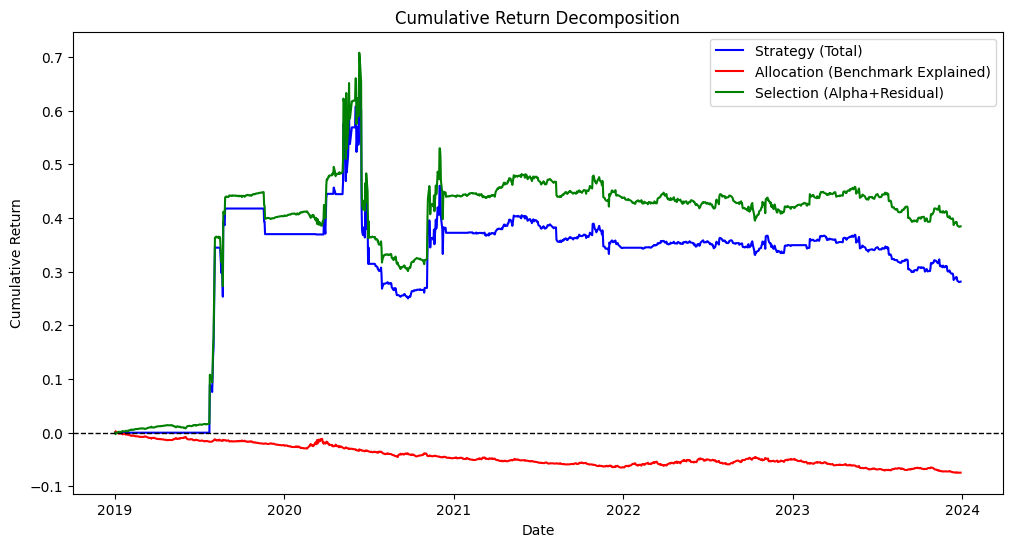

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(cumulative_strategy.index, cumulative_strategy, label='Strategy (Total)', color='blue')
ax.plot(cumulative_allocation.index, cumulative_allocation, label='Allocation (Benchmark Explained)', color='red')
ax.plot(cumulative_alpha_residual.index, cumulative_alpha_residual, label='Selection (Alpha+Residual)', color='green')
ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
# ax.axvline(x=test_train_split_line, color='orange', linewidth=1, linestyle='--', label='Test-Train Split')
ax.set_title('Cumulative Return Decomposition')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.legend()

plt.show()

The strategy’s returns are overwhelmingly dominated by selection effects (idiosyncratic stock-pair trades) rather than general market moves (benchmark).

The bulk of our strategy’s returns are coming from alpha (idiosyncratic gains not explained by the benchmark) and residuals (likely the mean-reversion profits you earn from our pairs trades).

## 5. Insight Utilization and Communication

The analysis shows that the selection effect, modeled by alpha and residual effects, dominates the share of returns. In other words, our pair selection methodology to identifying cointegrated pairs, and timing of entries/exits is adding significant value beyond simple exposure to the IT sector via the benchmark. 

Given that the allocation (benchmark-driven) effect was negligible, the strategy is effectively market-neutral and does not rely heavily on the direction of the specific sector or the broader equity market. This is a positive sign since our goal is to produce returns uncorrelated with standard market movements. However, it also means performance is entirely contingent on the successful exploitation of pair relationships. 

However, realistically, we will need to consider transaction costs and slippage. Trading costs may then reduce some of the realized alpha, and could provide a more conservative estimate of returns. Also, cointegration relationships and spread dynamics may change over time, so a periodic re-calibration of pairs and parameters may be necessary. Finally, high selection-driven returns often come from a small set of pairs. Ensuring diversification across multiple pairs and having robust stop-loss mechanisms can help us mitigate idiosyncratic risk.

As a potential adjustment to the strategy, we could consider introducing other common equity risk factors such as size, value, or momentum to understand if our alpha is purely idiosyncratic or if it can be decomposed further into known factor exposures.

In [20]:
aligned_data

,Strategy_Returns,XLK_Returns
2019-01-02,0.000000,0.000645
2019-01-03,0.000000,-0.050468
2019-01-04,0.000000,0.044320
2019-01-07,0.000000,0.008943
2019-01-08,0.000000,0.008381
...,...,...
2023-12-22,-0.002773,0.001303
2023-12-26,-0.001877,0.004166
2023-12-27,0.000316,-0.000052
2023-12-28,0.000144,0.001193


In [21]:
from datetime import datetime
import holoviews as hv
import hvplot.pandas
hv.extension('bokeh')
def performance_summary(return_data, annualization = 12):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    def sortino_ratio(column):
        negative_returns = return_data[column][return_data[column] < 0]
        downside_std = np.sqrt((negative_returns ** 2).mean()) * np.sqrt(annualization)
        return summary_stats.loc[column, 'Mean'] / downside_std if downside_std != 0 else np.nan

    # Apply the sortino_ratio function to each column in return_data
    summary_stats['Sortino Ratio'] = return_data.apply(lambda col: sortino_ratio(col.name), axis=0)

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

def plot_dashboard(return_data):
    cumulative_returns = (1 + return_data).cumprod() - 1
    plot = cumulative_returns.hvplot.line(y='Strategy_Returns', label='Strategy Returns', color='blue', width=1200, height=400)* \
                cumulative_returns.hvplot.line(y='XLK_Returns', label='Benchmark Returns', color='red')
    plot.opts(title='Strategy vs. Benchmark Returns', xlabel='Date', ylabel='Cumulative Return', active_tools=['box_zoom'])

    summary_stats = performance_summary(return_data, 252)
    summary_table = hv.Table(summary_stats.reset_index()).opts(title='Performance Summary', width=1200)

    dashboard = (plot + summary_table).cols(1)
    
    return dashboard

dash = plot_dashboard(aligned_data)
hv.save(dash, 'final_dashboard.html')

In [22]:
dash

:Layout
   .Overlay.I :Overlay
      .Curve.Strategy_Returns  :Curve   [index]   (Strategy_Returns)
      .Curve.Benchmark_Returns :Curve   [index]   (XLK_Returns)
   .Table.I   :Table   [index,Mean,Volatility,Sharpe Ratio,Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery]